In [ ]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

import warnings
warnings.filterwarnings('ignore')

In [2]:
class SentimentClassClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        output = self.out(output)
        
        return self.softmax(output)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
df_test = pd.read_csv('Data/test.csv')

In [5]:
MAX_LEN = 50

In [6]:
def encode_req(request, tokenizer, max_len):
    encoding = tokenizer.encode_plus(
                request,
                max_length=max_len,
                add_special_tokens=True,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
    )
    return encoding

In [7]:
import json
with open('Dicts/num_to_class.json') as f:
    num_to_class = json.load(f)

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
model = SentimentClassClassifier(len(num_to_class))

In [10]:
model.load_state_dict(torch.load('Model/best_model_state.bin'))
model = model.to(device)

In [11]:
!nvidia-smi

Wed Sep 23 02:33:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0    N/A /  N/A |   1760MiB /  4040MiB |     44%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
tokens_new = []
for text in df_test.text.values:
    encoding = tokenizer.encode_plus(
            str(text),
            max_length=MAX_LEN,
            add_special_tokens=True,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
    tokens_new.append(encoding['input_ids'].numpy().tolist()[0])
tokens_new = np.array(tokens_new)

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [14]:
X_emb = tsne.fit_transform(tokens_new)

In [15]:
labels_test = []
for text in df_test.text.values:
    encoding = encode_req(str(text), tokenizer, MAX_LEN)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, predict = torch.max(output, dim=1)
    labels_test.append(num_to_class[str(predict.item())])

In [16]:
df_out = pd.DataFrame({
    'id':df_test['id'],
    'label':labels_test
})

In [17]:
df_out.head()

,id,label
0,0,Мобильный интернет
1,1,мобильная связь - тарифы
2,2,Роуминг
3,3,мобильная связь - тарифы
4,4,Баланс


In [18]:
df_out.to_csv('Test_out.csv', index=False)

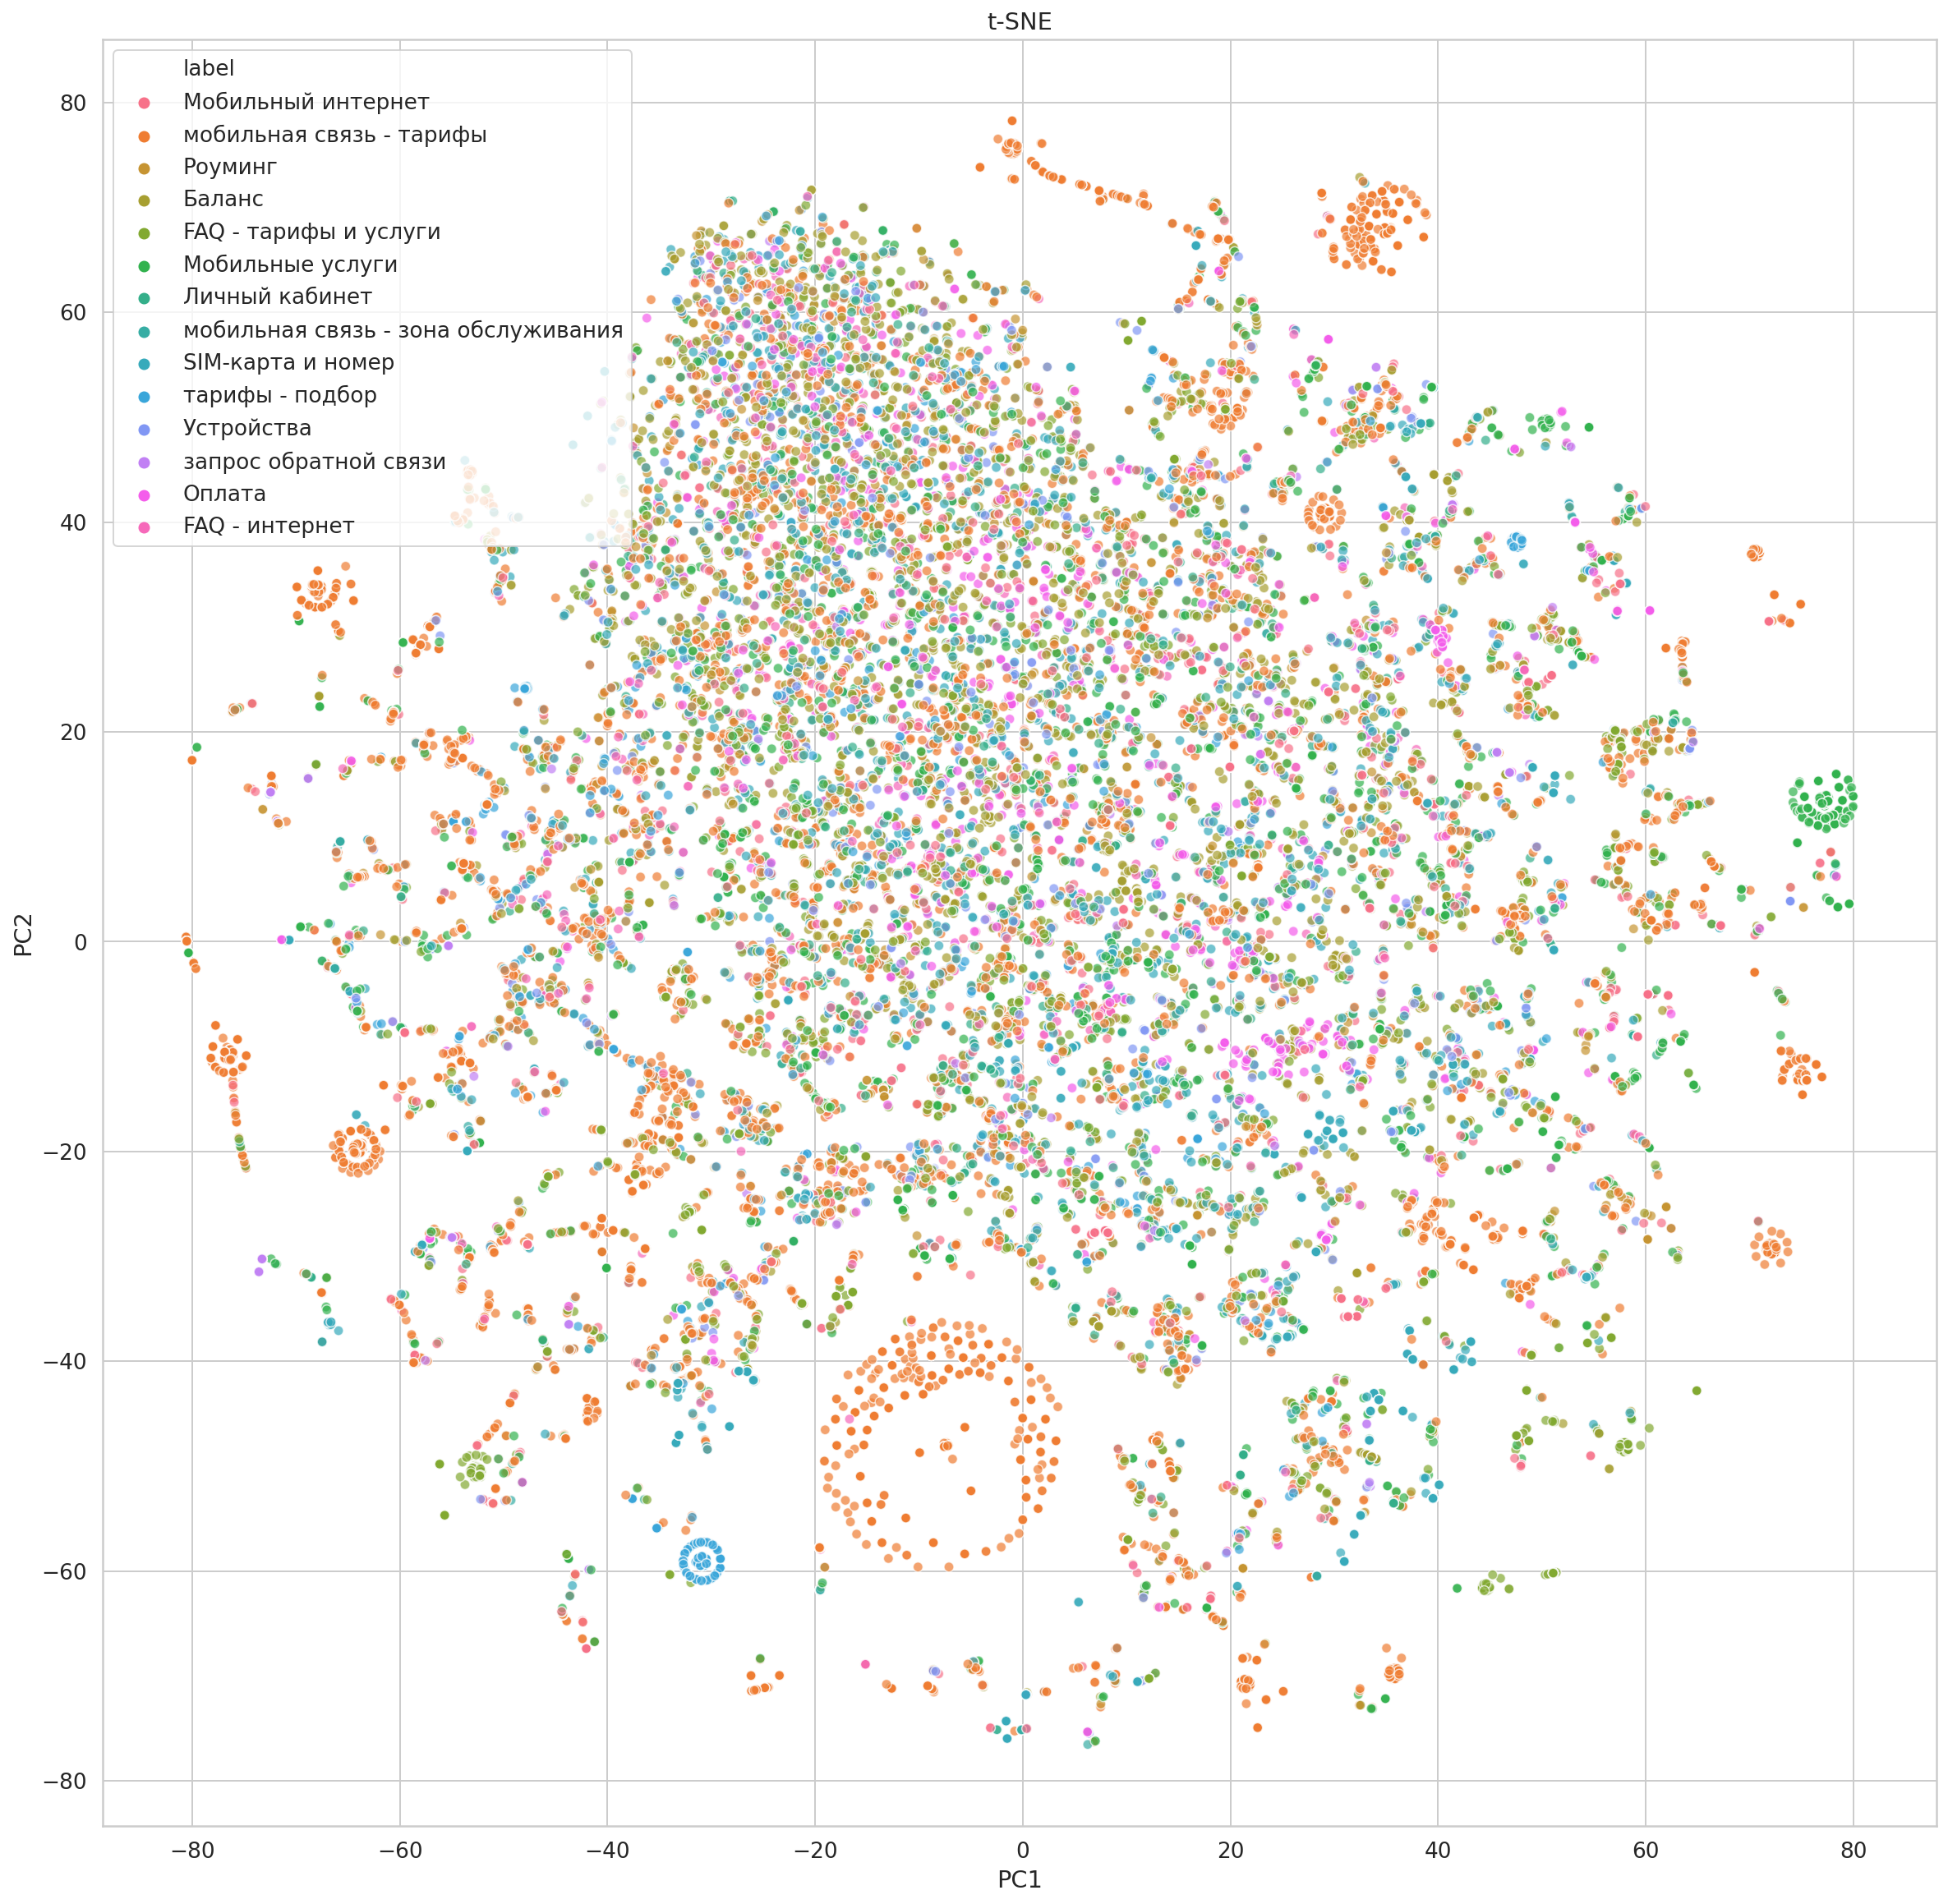

In [19]:
title = "t-SNE"
df_features = pd.DataFrame(data=X_emb,
                     columns=['PC1', 'PC2'])
df_labels = pd.DataFrame(data=df_out.label.values,
                             columns=['label'])
df_full = pd.concat([df_features, df_labels], axis=1)
plt.figure(figsize=(20,20))
sns.scatterplot(x='PC1',
                y='PC2',
                hue="label", 
                data=df_full,
                alpha=.7).set_title(title);